# **Analisis exploratorio de datos (EDA)**

---

Antes de proceder con el EDA, se proporcionará una breve explicación de los KPIs a utilizar.

### Análisis de Medias Móviles y Cruces (Moving Averages):

Una de las herramientas más ampliamente empleadas en el análisis técnico son las medias móviles. La media móvil representa el promedio de los precios de cierre de una acción durante un período de tiempo específico. La duración de dicho período puede variar según las metas del analista. Las medias móviles contribuyen a atenuar las fluctuaciones en los precios y pueden facilitar la identificación de tendencias a largo plazo.

El cruce de medias móviles se verifica cuando la media móvil a corto plazo (por ejemplo, 50 días) cruza ya sea por encima o por debajo de la media móvil a largo plazo (por ejemplo, 200 días). Un cruce alcista se da cuando la media móvil a corto plazo cruza sobre la media móvil a largo plazo, lo cual se considera una señal de compra. En contraste, un cruce bajista se produce cuando la media móvil a corto plazo cruza por debajo de la media móvil a largo plazo, lo cual se interpreta como una señal de venta.

### Índice de Fuerza Relativa (RSI):

El RSI es un indicador de impulso que mide la fuerza de la tendencia alcista o bajista de una acción y se expresa en una escala de 0 a 100. Un RSI por encima de 70 indica que la acción está sobrecomprada, lo que significa que el precio ha subido demasiado rápido y puede estar a punto de corregir a la baja. Un RSI por debajo de 30 indica que la acción está sobrevendida, lo que significa que el precio ha caído demasiado rápido y puede estar a punto de corregir al alza. El RSI también se puede utilizar para identificar divergencias entre el precio y el impulso, lo que puede ser una señal de una posible inversión de la tendencia.

### Volumen:

Este indicador resulta esencial porque refleja el nivel de interés y participación de los inversores en una criptomoneda en particular. Cuando el volumen es alto, suele indicar un mayor grado de actividad comercial, lo que podría estar asociado a movimientos significativos en los precios. Por otro lado, un volumen bajo podría sugerir una menor liquidez y un menor interés de los inversores en ese momento.

---

Para llevar a cabo la extracción de datos, el cálculo y el análisis técnico gráfico de criptomonedas, se importarán las siguientes librerías en Python

In [96]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import ta


Se crean las funciones para poder extraer la informacion necesaria de la API de CoinGecko.

In [97]:

def get_top_crypto_ids(limit=10):
    """
    Obtiene los IDs de las principales criptomonedas según su capitalización de mercado.

    Parámetros:
        limit (int): Número máximo de criptomonedas a obtener.

    Retorna:
        crypto_ids (list): Lista de IDs de las criptomonedas.
    """
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": limit,
        "page": 1,
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        crypto_ids = [crypto["id"] for crypto in data]
        return crypto_ids
    else:
        print("Error al obtener la lista de criptomonedas")
        return []

def get_crypto_price_history(crypto_id):
    """
    Obtiene el historial de precios de una criptomoneda en particular.

    Parámetros:
        crypto_id (str): ID de la criptomoneda.

    Retorna:
        data (dict): Datos del historial de precios de la criptomoneda.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "max", # Ingresamos max para evitar nulos
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error al obtener datos de la API para {crypto_id}")
        return None

def get_top_crypto_data(num_coins):
    """
    Obtiene información detallada de las principales criptomonedas según su capitalización de mercado.

    Parámetros:
        num_coins (int): Número de criptomonedas principales a obtener.

    Retorna:
        crypto_df (DataFrame): DataFrame con la información de las criptomonedas.
    """
    url_top_coins = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={num_coins}&page=1"
    response_top_coins = requests.get(url_top_coins)
    top_coins_info = response_top_coins.json()

    crypto_data = []

    for coin_info in top_coins_info:
        coin_name = coin_info.get('name')
        coin_id = coin_info.get('id')
        max_supply = coin_info.get('max_supply', None)
        circulating_supply = coin_info.get('circulating_supply', None)
        current_price = coin_info.get('current_price', None)
        price_change_24h = coin_info.get('price_change_percentage_24h', None)
        market_cap_rank = coin_info.get('market_cap_rank', None)
        market_cap = coin_info.get('market_cap', None)
        volume_24h = coin_info.get('total_volume', None)

        crypto_data.append({
            'Coin': coin_name,
            'Max Supply': max_supply,
            'Circulating Supply': circulating_supply,
            'Current Price (USD)': current_price,
            'Price Change 24h (%)': price_change_24h,
            'Market Cap Rank': market_cap_rank,
            'Market Cap (USD)': market_cap,
            'Volume 24h (USD)': volume_24h,
            'CoinGecko ID': coin_id,
        })
    crypto_df = pd.DataFrame(crypto_data)
    return crypto_df





Utilizando un criterio de selección basado en la capitalización de mercado, se procederá a la elección de las 10 criptomonedas más importantes en el mercado. Para garantizar la integridad de los datos, se obtendrán registros históricos de las 10 principales criptomonedas en términos de capitalización de mercado.

Se implementará un parámetro "days" con el valor "max" al solicitar los datos. Esto permitirá obtener información desde la fecha de creación de cada criptomoneda hasta la fecha actual, evitando así la presencia de datos nulos o incompletos.

In [98]:
# Obtiene los IDs de las 10 principales criptomonedas
top_crypto_ids = get_top_crypto_ids(limit=10)

# Lista para almacenar los datos procesados de las criptomonedas
crypto_data = []

# Itera sobre cada ID de criptomoneda
for crypto_id in top_crypto_ids:
    # Obtiene el historial de precios para la criptomoneda actual
    historial_crypto = get_crypto_price_history(crypto_id)
    
    # Si se obtuvo el historial exitosamente
    if historial_crypto:
        # Extrae las marcas de tiempo, precios, volúmenes y capitalizaciones de mercado
        timestamps = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in historial_crypto["prices"]]
        prices = [price for _, price in historial_crypto["prices"]]
        volumes = [volume for _, volume in historial_crypto["total_volumes"]]
        market_caps = [market_cap for _, market_cap in historial_crypto["market_caps"]]
        
        # Agrega los datos de la criptomoneda actual a la lista crypto_data
        crypto_data.append({
            "Crypto": crypto_id.capitalize(),
            "Timestamp": timestamps,
            "Price": prices,
            "Volume": volumes,
            "Market Cap": market_caps
        })

# Combina los datos de las criptomonedas en un DataFrame
df = pd.concat([pd.DataFrame(data) for data in crypto_data], ignore_index=True)

Para llevar a cabo un análisis técnico más completo de las criptomonedas, se realizará el cálculo del índice de fuerza relativa (RSI) y se calcularán las medias móviles de 50 y 100 días. Estos indicadores proporcionarán una visión más profunda de las tendencias y la posible fuerza del mercado. Ademas de calculara la variazion diaria del precio para complementar el analisis.

In [99]:
# Ordena el DataFrame por Criptomoneda y marca de tiempo
df = df.sort_values(by=['Crypto', 'Timestamp'])

# Calcula la variación porcentual del precio por día para cada Criptomoneda
df['Variación_Precio'] = df.groupby('Crypto')['Price'].pct_change()

# Rellena valores infinitos o NaN en la columna de variación con 0
df['Variación_Precio'] = df['Variación_Precio'].fillna(0)

# Muestra el DataFrame resultante con los datos procesados
df['SMA50'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=50).sma_indicator())
df['SMA200'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.trend.SMAIndicator(x, window=200).sma_indicator())
df['RSI'] = df.groupby('Crypto')['Price'].transform(lambda x: ta.momentum.RSIIndicator(x, window=14).rsi())

df


,Crypto,Timestamp,Price,Volume,Market Cap,Variación_Precio,SMA50,SMA200,RSI
9766,Binancecoin,2017-09-16 00:00:00,0.107251,1.051223e+00,1.072506e+07,0.000000,NaN,NaN,NaN
9767,Binancecoin,2017-09-17 00:00:00,0.154041,1.467859e+01,1.540413e+07,0.436274,NaN,NaN,NaN
9768,Binancecoin,2017-09-18 00:00:00,0.173491,6.001767e+00,1.734912e+07,0.126265,NaN,NaN,NaN
9769,Binancecoin,2017-09-19 00:00:00,0.168334,3.878927e+00,1.683342e+07,-0.029725,NaN,NaN,NaN
9770,Binancecoin,2017-09-20 00:00:00,0.166628,4.068762e+01,1.666279e+07,-0.010136,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
17360,Usd-coin,2023-08-13 00:00:00,0.999880,1.242418e+09,2.616194e+10,-0.000389,1.000031,1.000150,48.677099
17361,Usd-coin,2023-08-14 00:00:00,0.999981,1.681827e+09,2.618058e+10,0.000101,1.000029,1.000145,49.385706
17362,Usd-coin,2023-08-15 00:00:00,0.999688,2.461886e+09,2.600436e+10,-0.000292,1.000035,1.000139,47.340913
17363,Usd-coin,2023-08-16 00:00:00,0.999975,3.215612e+09,2.603284e+10,0.000286,1.000007,1.000134,49.545438


Obtenemos los datos en tiempo real de las 10 cryptomonedas con mayor capitalizacion 

In [100]:
# Obtener los datos de las 10 principales criptomonedas utilizando la funcion creada anteriormente llamada get_top_crypto_data
top_crypto_df = get_top_crypto_data(10)
top_crypto_df


,Coin,Max Supply,Circulating Supply,Current Price (USD),Price Change 24h (%),Market Cap Rank,Market Cap (USD),Volume 24h (USD),CoinGecko ID
0,Bitcoin,2.100000e+07,1.945882e+07,29139.000000,-0.62306,1,566668373525,12554631888,bitcoin
1,Ethereum,NaN,1.201391e+08,1821.750000,-1.00241,2,218796175433,5456482221,ethereum
2,Tether,NaN,8.318200e+10,0.999051,0.03541,3,83103021872,19979159338,tether
3,BNB,2.000000e+08,1.538562e+08,234.660000,-1.87739,4,36098185826,471105301,binancecoin
4,XRP,1.000000e+11,5.278728e+10,0.602792,-3.95258,5,31821018217,1333290652,ripple
5,USD Coin,NaN,2.603383e+10,1.001000,0.08788,6,26041045083,2782254785,usd-coin
6,Lido Staked Ether,8.134645e+06,8.134645e+06,1820.410000,-1.07077,7,14801786037,29189590,staked-ether
7,Dogecoin,NaN,1.406099e+11,0.070601,-4.91460,8,9926060734,544398452,dogecoin
8,Cardano,4.500000e+10,3.504502e+10,0.278833,-3.47711,9,9767507313,200674021,cardano
9,Solana,NaN,4.062736e+08,23.460000,-5.98420,10,9522725289,457173477,solana


Es evidente que existe una notable tendencia en la que las altcoins siguen de cerca las fluctuaciones de Bitcoin en el mercado de criptomonedas. Esto sugiere una alta correlación entre el precio de Bitcoin y el comportamiento de muchas otras criptomonedas alternativas. Esta relación tan estrecha entre Bitcoin y las altcoins ha llevado a la percepción de que gran parte del mercado criptográfico se encuentra influenciado por la dirección que toma el precio de Bitcoin.

Se ha observado que durante los períodos de declive en el precio de Bitcoin, la mayoría de las altcoins también experimentan caídas en sus valores. Sin embargo, es importante destacar que existen casos excepcionales donde algunas altcoins demuestran una resistencia notable frente a la caída del precio de Bitcoin. En estas situaciones, ciertas altcoins muestran un piso sólido en comparación con otras que experimentan caídas más pronunciadas.



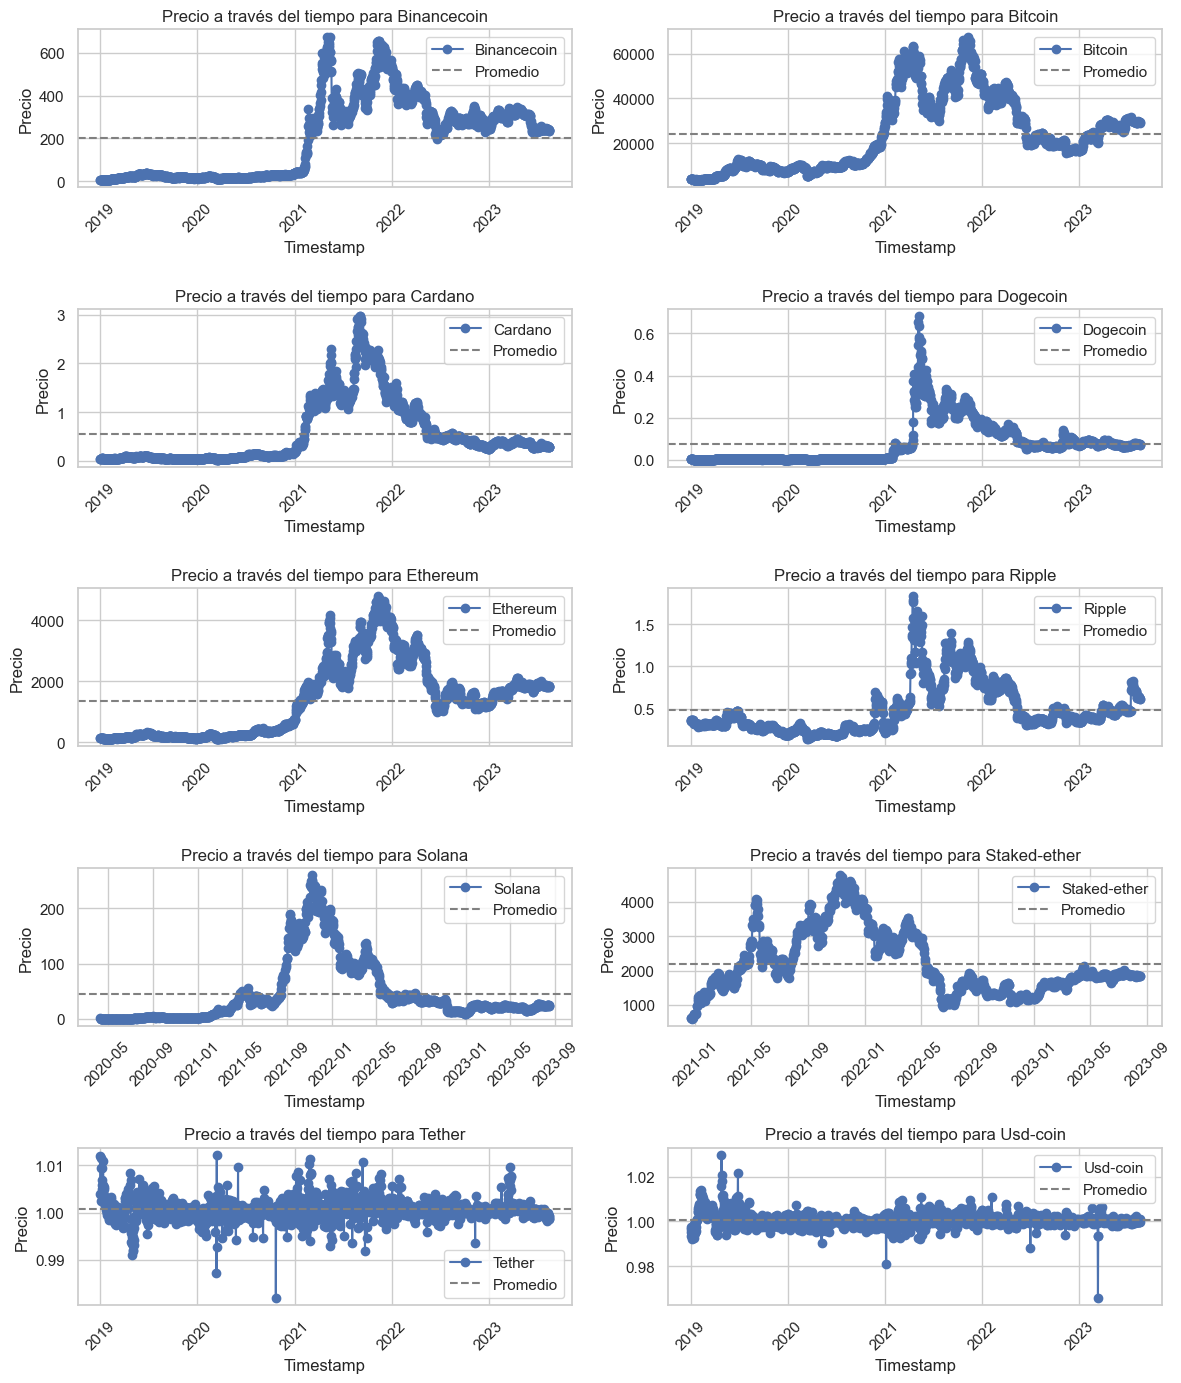

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que df contiene tus datos y tienes una columna 'Timestamp' en formato de fecha
# Convierte la columna 'Timestamp' a tipo datetime si aún no lo está
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtra los datos para incluir solo los registros a partir de 2019
df = df[df['Timestamp'].dt.year >= 2019]

unique_cryptos = df['Crypto'].unique()  # Obtén la lista de criptomonedas únicas

# Calcula el número de filas y columnas para la cuadrícula
num_cols = 2  # Puedes ajustar el número de columnas según tus preferencias
num_rows = -(-len(unique_cryptos) // num_cols)  # Redondeo hacia arriba de la división

# Crea la cuadrícula de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))  # Ajusta el tamaño según tus preferencias

# Itera a través de las criptomonedas y los subplots correspondientes
for i, crypto_name in enumerate(unique_cryptos):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    crypto_data = df[df['Crypto'] == crypto_name]
    ax.plot(crypto_data['Timestamp'], crypto_data['Price'], label=crypto_name, marker='o')
    
    # Calcula y agrega la línea de promedio del precio
    average_price = crypto_data['Price'].mean()
    ax.axhline(y=average_price, color='gray', linestyle='--', label='Promedio')
    
    ax.set_title(f'Precio a través del tiempo para {crypto_name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Precio')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)  # Rotación de las etiquetas en el eje x
    ax.grid(True)

# Ajusta el espaciado entre los subplots y muestra el gráfico
plt.tight_layout()
plt.show()


Podemos observar que las criptomonedas que mejor mantienen su precio por encima de la media son aquellas que mantienen un volumen de transacciones considerable a lo largo del tiempo.

C:\Users\sarau\AppData\Local\Temp\ipykernel_2524\1726683523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


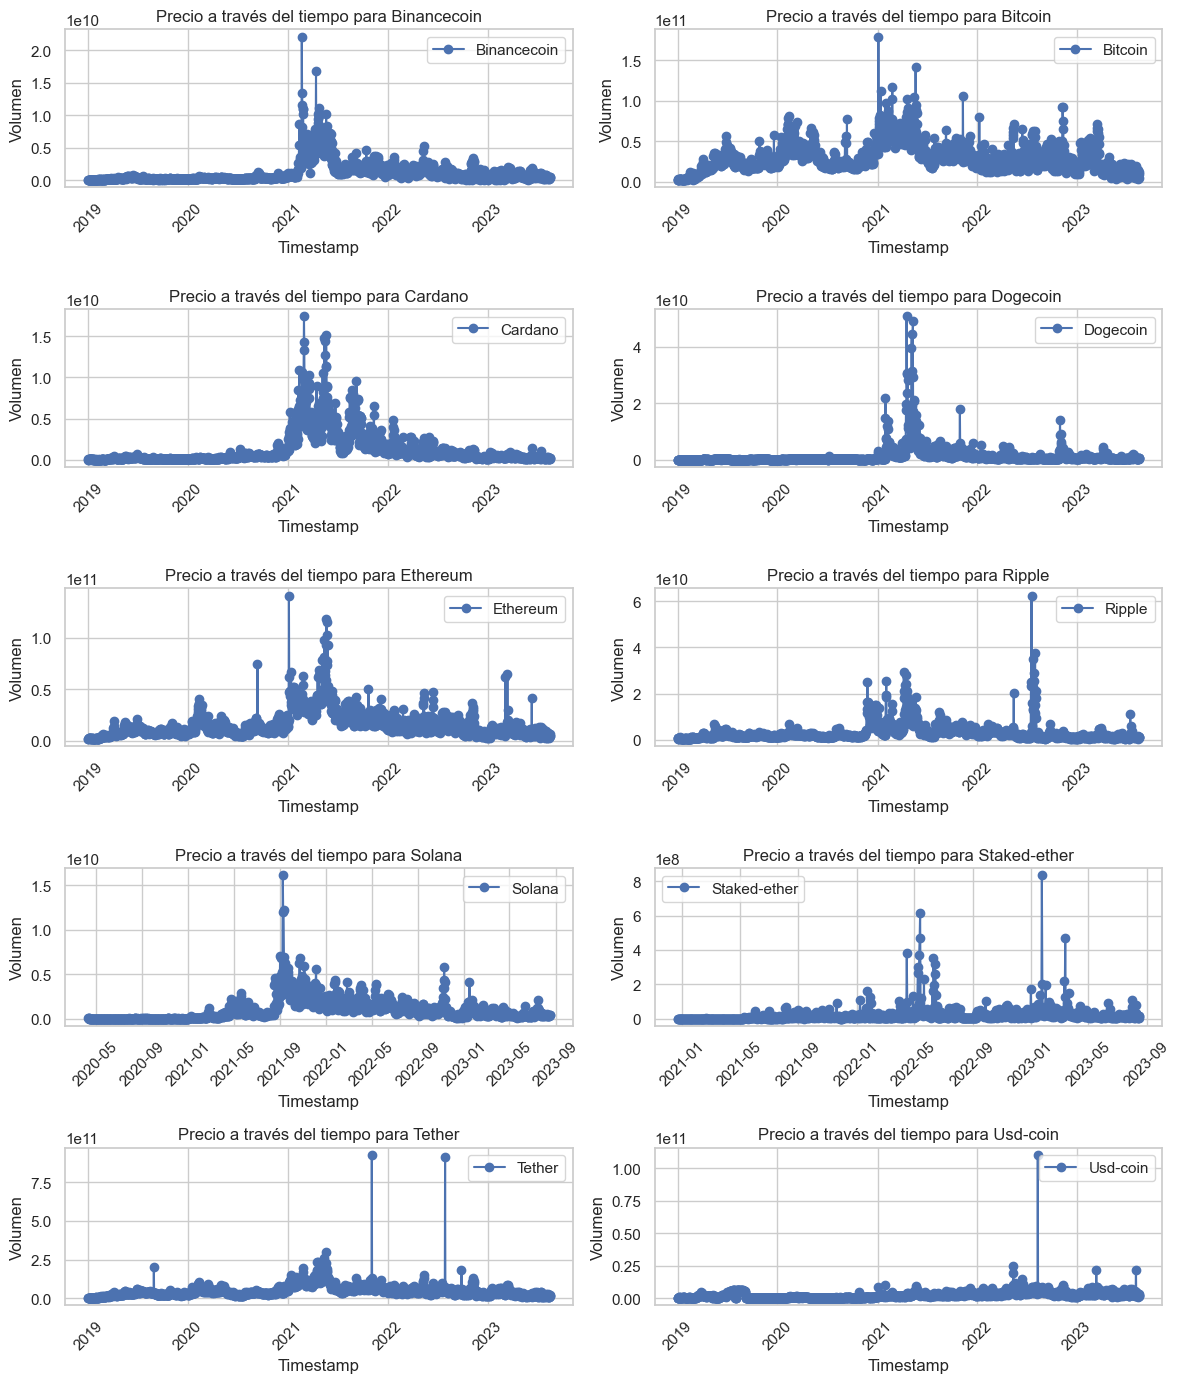

In [102]:

# Suponiendo que df contiene tus datos y tienes una columna 'Timestamp' en formato de fecha
# Convierte la columna 'Timestamp' a tipo datetime si aún no lo está
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtra los datos para incluir solo los registros a partir de 2018
df = df[df['Timestamp'].dt.year >= 2019]

unique_cryptos = df['Crypto'].unique()  # Obtén la lista de criptomonedas únicas

# Calcula el número de filas y columnas para la cuadrícula
num_cols = 2  # Puedes ajustar el número de columnas según tus preferencias
num_rows = -(-len(unique_cryptos) // num_cols)  # Redondeo hacia arriba de la división

# Crea la cuadrícula de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))  # Ajusta el tamaño según tus preferencias

# Itera a través de las criptomonedas y los subplots correspondientes
for i, crypto_name in enumerate(unique_cryptos):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    crypto_data = df[df['Crypto'] == crypto_name]
    ax.plot(crypto_data['Timestamp'], crypto_data['Volume'], label=crypto_name, marker='o')
    ax.set_title(f'Precio a través del tiempo para {crypto_name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Volumen')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)  # Rotación de las etiquetas en el eje x
    ax.grid(True)

# Ajusta el espaciado entre los subplots y muestra el gráfico
plt.tight_layout()
plt.show()

Estamos analizando el precio en conjunto con sus medias móviles y los puntos en que se cruzan. La conclusión será proporcionada más adelante.

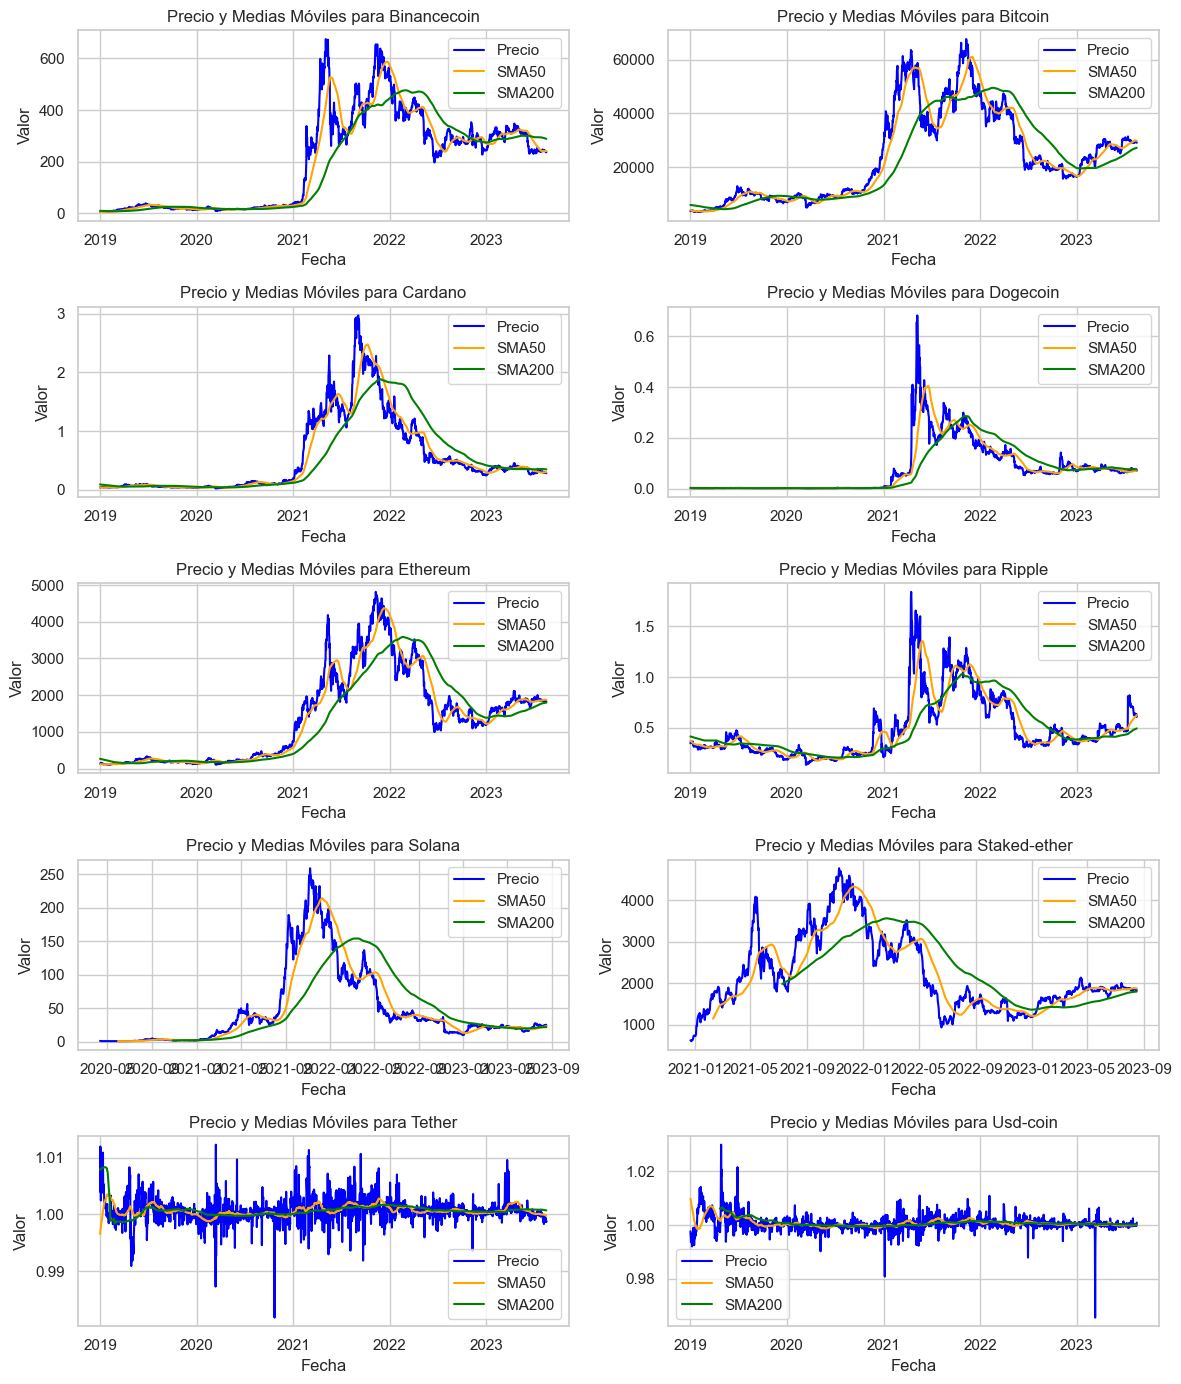

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que df contiene tus datos y tienes una columna 'Timestamp' en formato de fecha
# Convierte la columna 'Timestamp' a tipo datetime si aún no lo está
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

unique_cryptos = df['Crypto'].unique()  # Obtén la lista de criptomonedas únicas

# Calcula el número de filas y columnas para la cuadrícula
num_cols = 2  # Puedes ajustar el número de columnas según tus preferencias
num_rows = -(-len(unique_cryptos) // num_cols)  # Redondeo hacia arriba de la división

# Crea la cuadrícula de subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 14))  # Ajusta el tamaño según tus preferencias

# Función para graficar el precio y las medias móviles en un subplot
def plot_crypto_price_with_smavgs_subplot(crypto_df, ax):
    ax.plot(crypto_df['Timestamp'], crypto_df['Price'], label='Precio', color='blue')
    ax.plot(crypto_df['Timestamp'], crypto_df['SMA50'], label='SMA50', color='orange')
    ax.plot(crypto_df['Timestamp'], crypto_df['SMA200'], label='SMA200', color='green')
    ax.set_title(f"Precio y Medias Móviles para {crypto_df['Crypto'].iloc[0]}")
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(True)

# Itera a través de las criptomonedas y los subplots correspondientes
for i, crypto_name in enumerate(unique_cryptos):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    crypto_df = df[df['Crypto'] == crypto_name]
    plot_crypto_price_with_smavgs_subplot(crypto_df, ax)

# Ajusta el espaciado entre los subplots y muestra el gráfico
plt.tight_layout()
plt.show()



Estamos analizando el ROI (Retorno de la Inversión) en conjunto con sus límites.

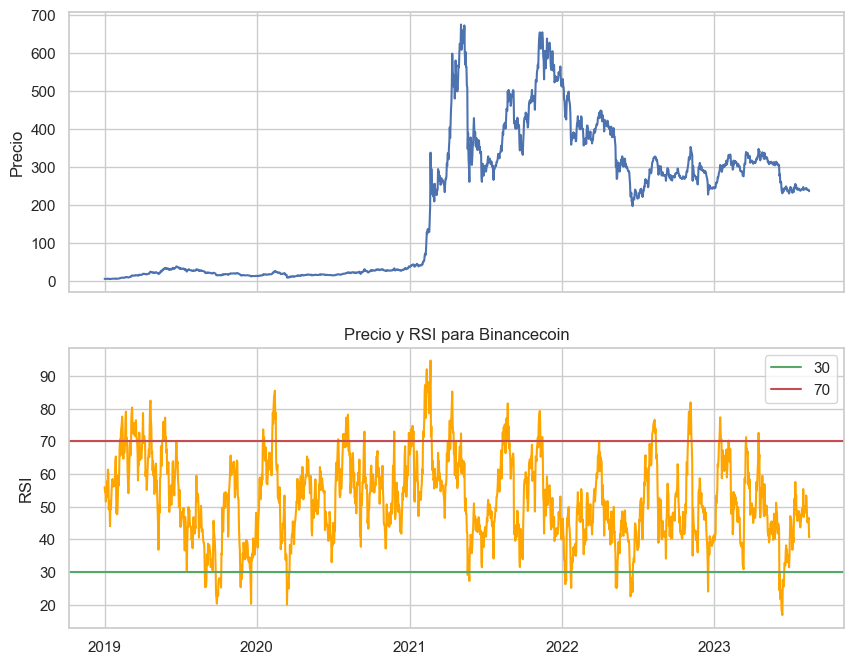

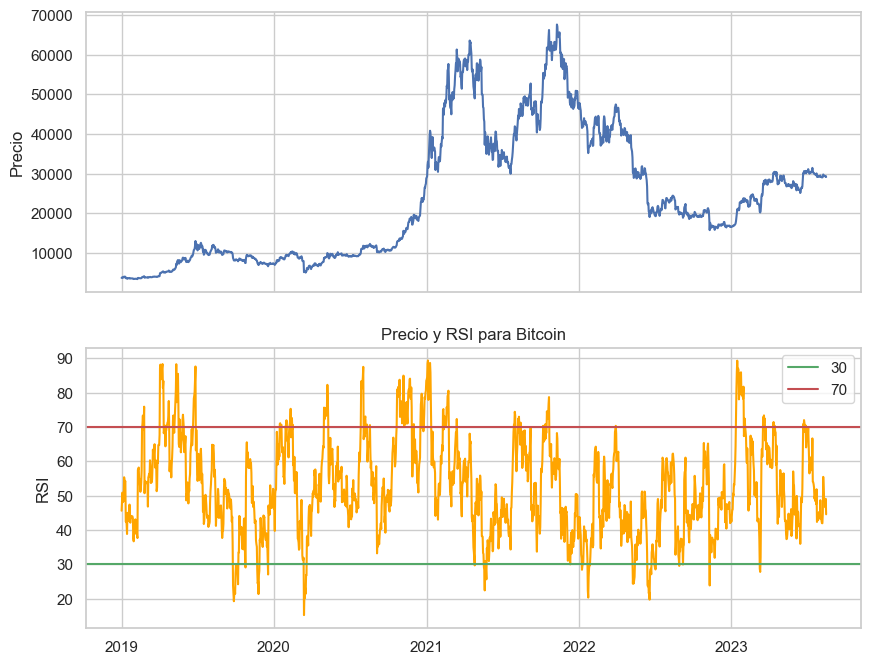

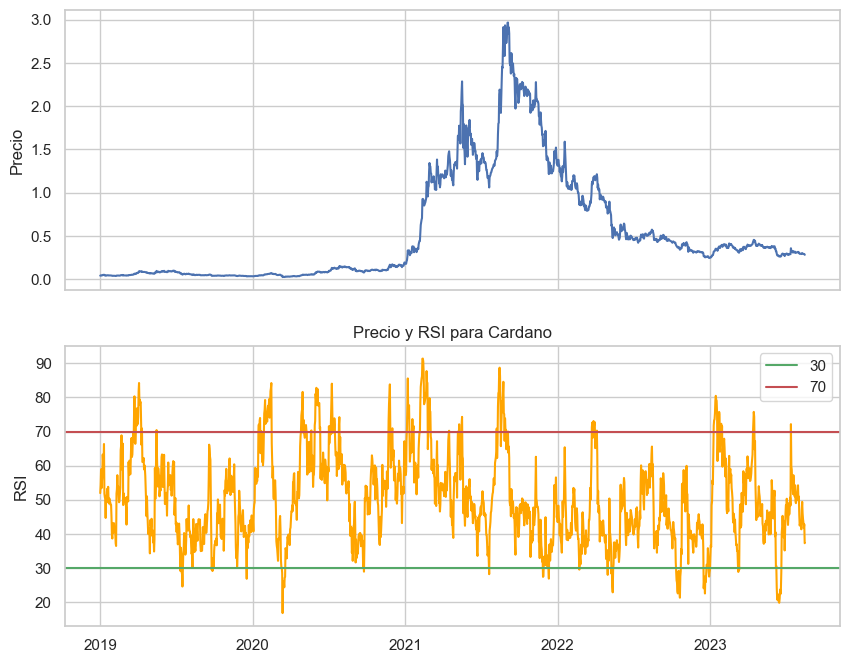

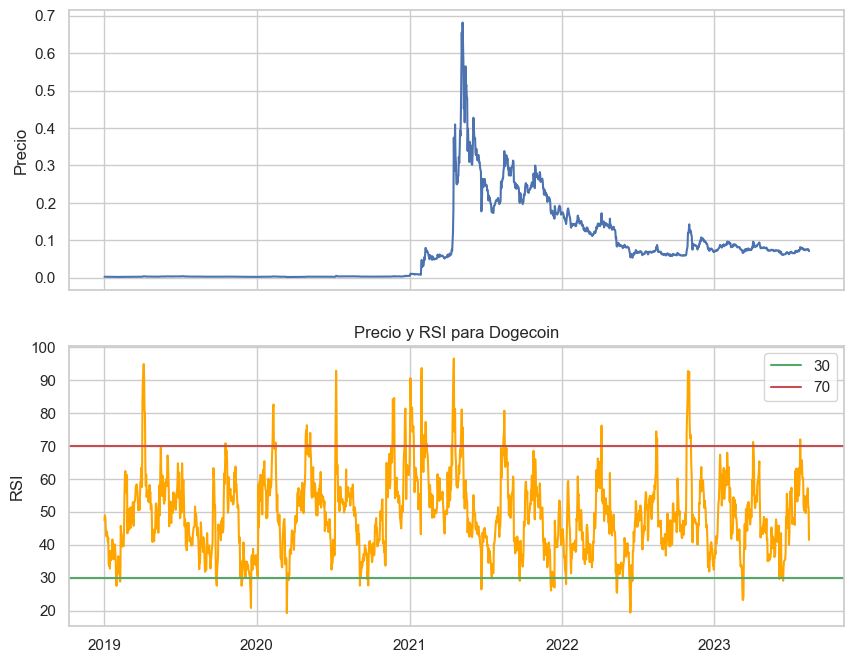

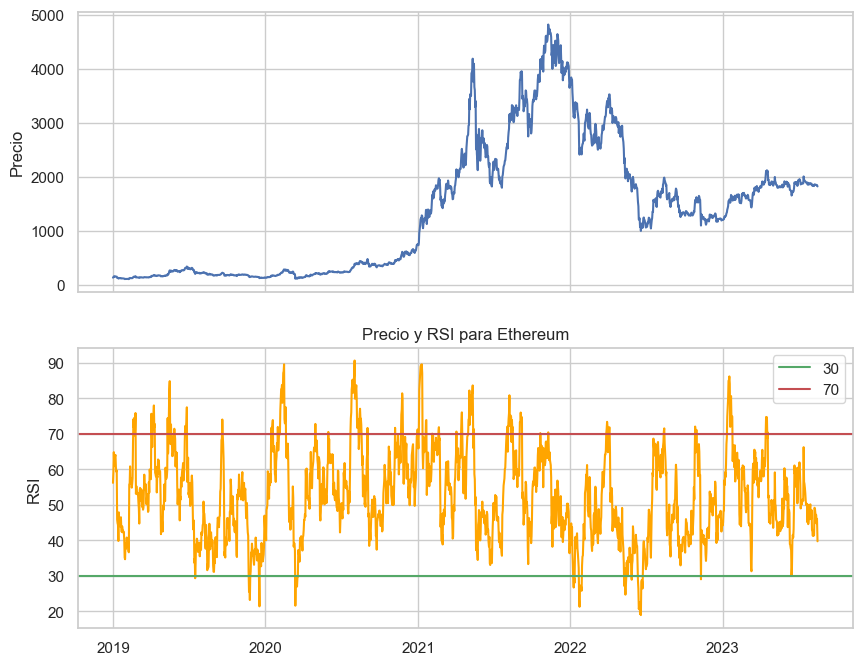

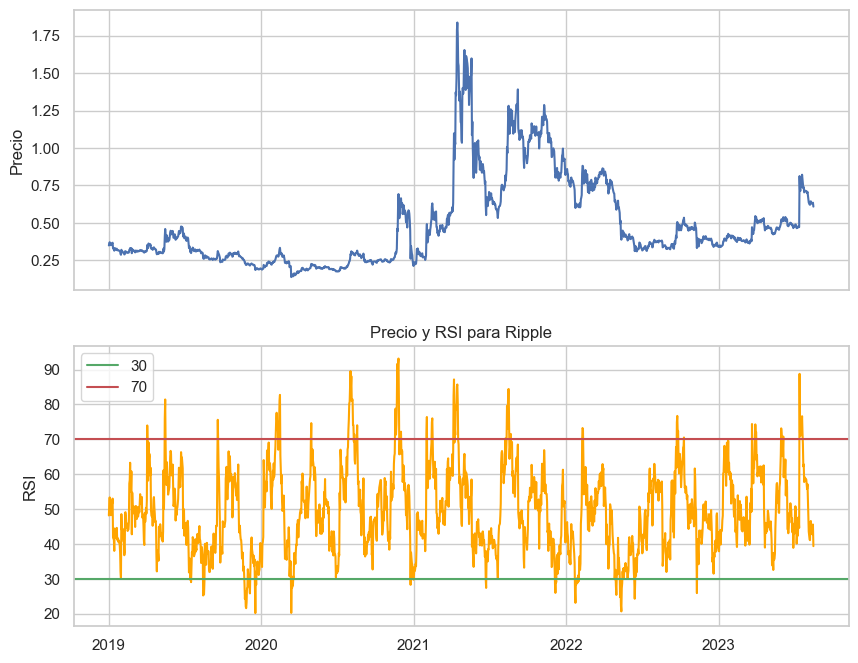

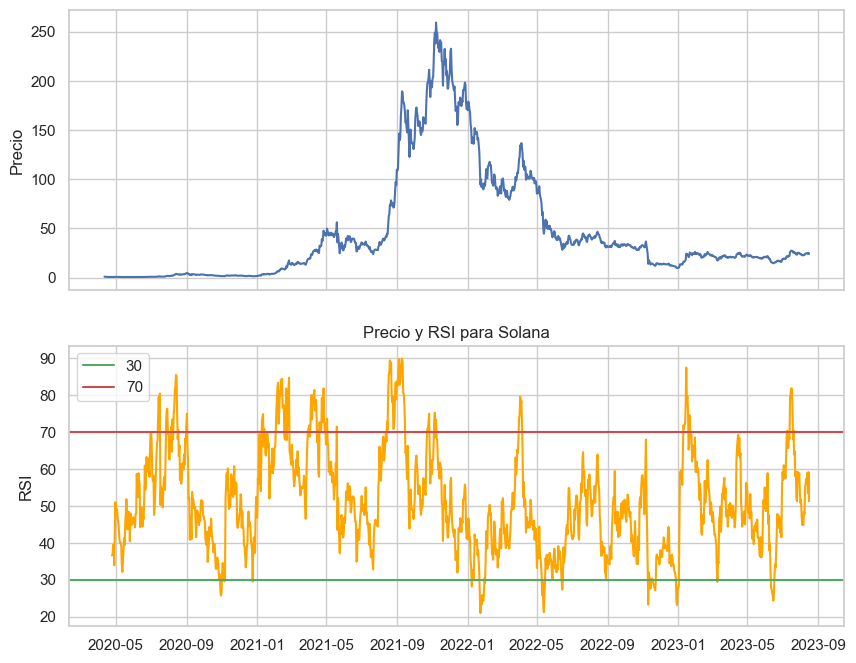

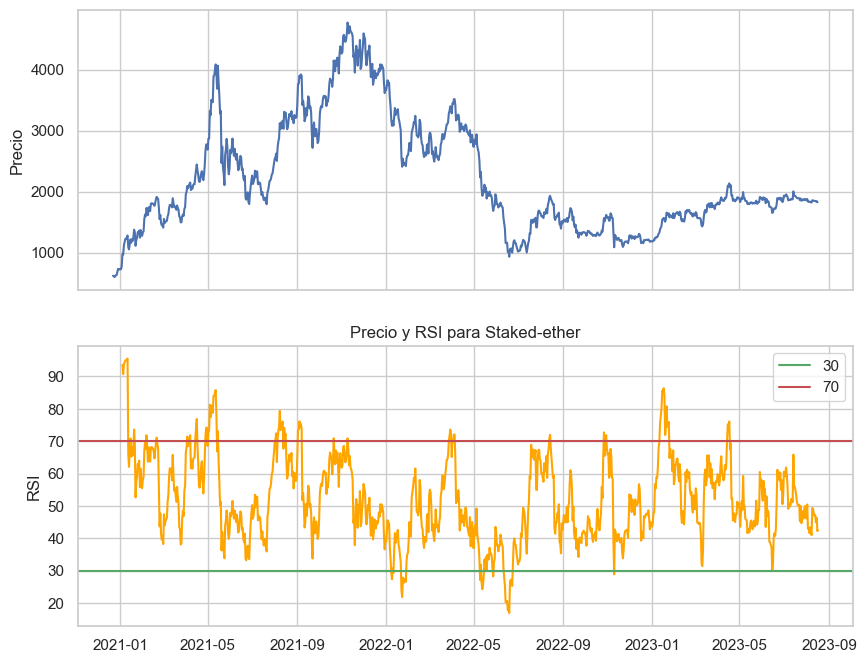

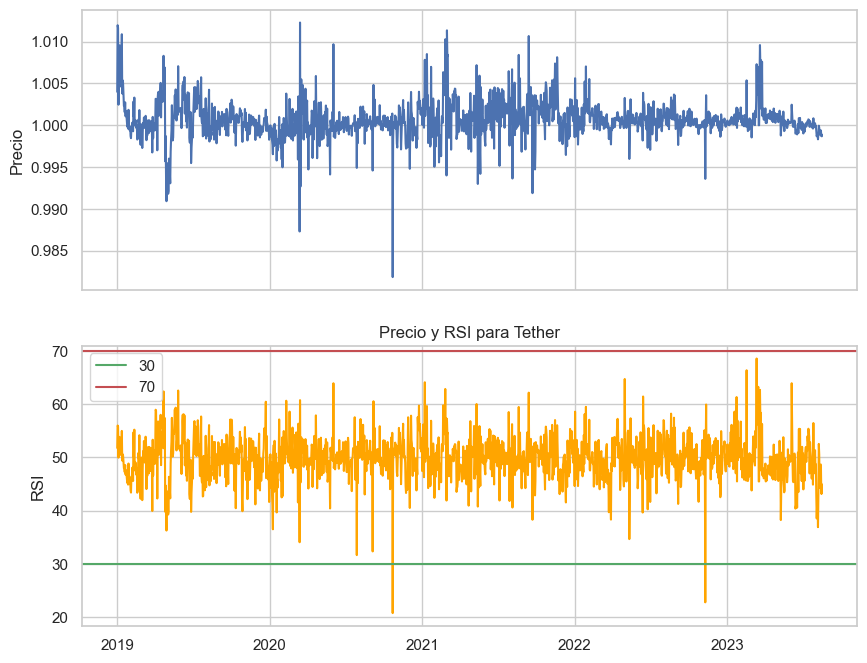

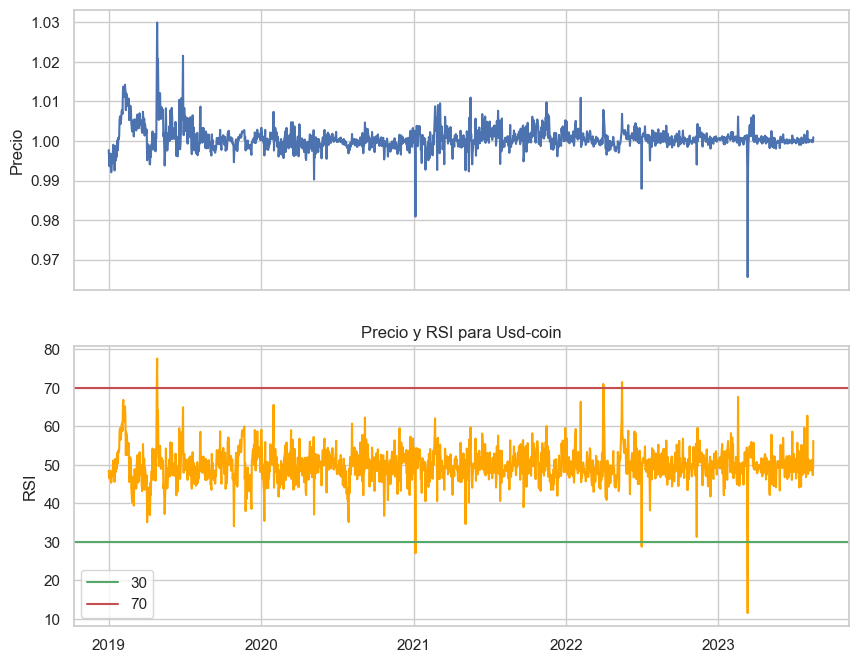

In [104]:

# Graficar los precios y el RSI
for crypto_name in df['Crypto'].unique():
    crypto_df = df[df['Crypto'] == crypto_name]
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax[0].plot(crypto_df['Timestamp'], crypto_df['Price'])
    ax[0].set_ylabel('Precio')
    ax[1].plot(crypto_df['Timestamp'], crypto_df['RSI'], color='orange')
    ax[1].set_ylabel('RSI')
    ax[1].axhline(y=30, color='g', linestyle='-', label='30')
    ax[1].axhline(y=70, color='r', linestyle='-', label='70')
    ax[1].legend()
    plt.title(f"Precio y RSI para {crypto_name}")
    plt.show()


# **Conclusion**

Primero que todo, definiremos qué stablecoin utilizaremos, eligiendo entre USD Coin y Tether, para salvaguardarnos en caso de que deseemos comprar o vender. La opción más segura parece ser Tether, debido a su mayor capitalización y un volumen que respalda su prominencia en el mercado.

En lo que respecta a invertir en cualquier criptomoneda, actualmente no se perciben señales evidentes de un aumento sustancial en el corto plazo. Sin embargo, a largo plazo, la inversión más segura parece ser en Bitcoin. Esta criptomoneda lidera en términos de capitalización de mercado, abarcando casi el 50%. Además, su suministro está limitado, lo que implica que cuando alcance este límite, su valor podría aumentar significativamente debido al principio de oferta y demanda. 

Existen otras criptomonedas que muestran una solidez notable en sus precios y suelen mantener un nivel de soporte destacado durante las caídas de Bitcoin. Entre estas monedas destacan Binance Coin (BNB) y Ethereum. Ambas monedas no solo han demostrado estabilidad, sino que también cuentan con un volumen diario considerable en términos de operaciones.

Esta robustez en el precio puede deberse a la diversificación del uso de Ethereum, ya que no solo se trata de una criptomoneda sino también de una plataforma para contratos inteligentes y aplicaciones descentralizadas. Por otro lado, Binance Coin ha ganado solidez al respaldar la infraestructura de la plataforma Binance y su ecosistema, que incluye intercambios y servicios diversos.